In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

%matplotlib inline


In [2]:
data = pd.read_csv('Downloads\LHR-ATH_fares.csv')
data = data.append(pd.read_csv('Downloads\LGW-ATH_fares.csv'),ignore_index=True)
data = data.append(pd.read_csv('Downloads\STN-ATH_fares.csv'),ignore_index=True)
data = data.append(pd.read_csv('Downloads\LTN-ATH_fares.csv'),ignore_index=True)

In [3]:
data['Day'] = data['Flight Date'].apply(lambda x: pd.to_datetime(x).day)
data['Month'] = data['Flight Date'].apply(lambda x: pd.to_datetime(x).month)
data['Year'] = data['Flight Date'].apply(lambda x: pd.to_datetime(x).year)

data['Dep Time (local)'] = pd.to_datetime(data['Dep Time (local)']).dt.time
data['Arr Time (local)'] = pd.to_datetime(data['Arr Time (local)']).dt.time

data = data[['Origin', 'Destination', 'Airline', 'Flight Date', 'Day', 'Month', 'Year', 'Weekday',
       'Dep Time (local)', 'Arr Time (local)', 'Price', 'Currency',
       'Fare Extraction Date']]

In [4]:
data.head()

,Origin,Destination,Airline,Flight Date,Day,Month,Year,Weekday,Dep Time (local),Arr Time (local),Price,Currency,Fare Extraction Date
0,LHR,ATH,British Airways,2020-04-16,16,4,2020,Thursday,08:40:00,14:30:00,393,GBP,2020-04-15
1,LHR,ATH,British Airways,2020-04-17,17,4,2020,Friday,13:15:00,19:00:00,200,GBP,2020-04-15
2,LHR,ATH,British Airways,2020-04-18,18,4,2020,Saturday,08:45:00,14:35:00,293,GBP,2020-04-15
3,LHR,ATH,British Airways,2020-04-19,19,4,2020,Sunday,13:05:00,18:50:00,314,GBP,2020-04-15
4,LHR,ATH,British Airways,2020-04-20,20,4,2020,Monday,08:50:00,14:40:00,293,GBP,2020-04-15


**Explore all months**

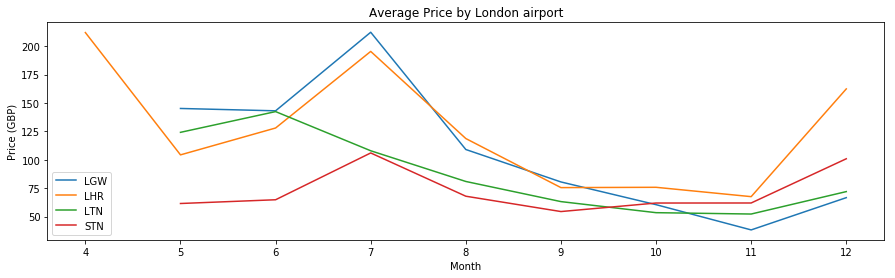

In [5]:
by_airport_month = pd.DataFrame(data.groupby(['Origin','Month'])['Price'].mean()).reset_index()
plt.figure(figsize=(15, 4))
for origin in by_airport_month['Origin'].unique():
    plt.plot(by_airport_month[by_airport_month['Origin']==origin]['Month'],by_airport_month[by_airport_month['Origin']==origin]['Price'],label=origin)
plt.xlabel('Month')
plt.ylabel('Price (' + data.iloc[0].Currency + ')')
plt.title('Average Price by London airport')
plt.legend()
plt.show()

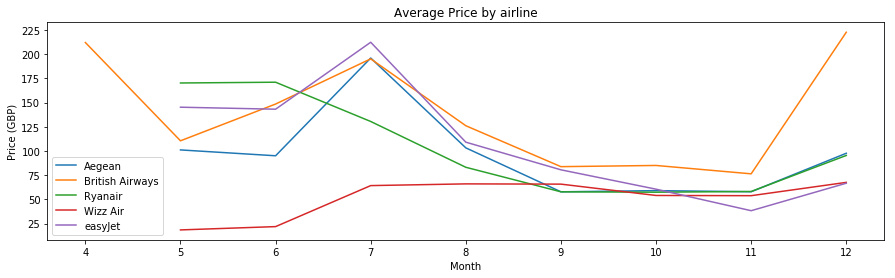

In [6]:
by_airline_month = pd.DataFrame(data.groupby(['Airline','Month'])['Price'].mean()).reset_index()
airlines_list = by_airline_month['Airline'].unique()
plt.figure(figsize=(15, 4)) 

for airline in airlines_list:
    plt.plot(by_airline_month[by_airline_month['Airline']==airline]['Month'],by_airline_month[by_airline_month['Airline']==airline]['Price'],label=airline)
plt.xlabel('Month')
plt.ylabel('Price (' + data.iloc[0].Currency + ')')
plt.title('Average Price by airline')
plt.legend()
plt.show()

**Explore selected month**

In [7]:
month = 5
month_name = datetime.date(1900, month, 1).strftime('%B')

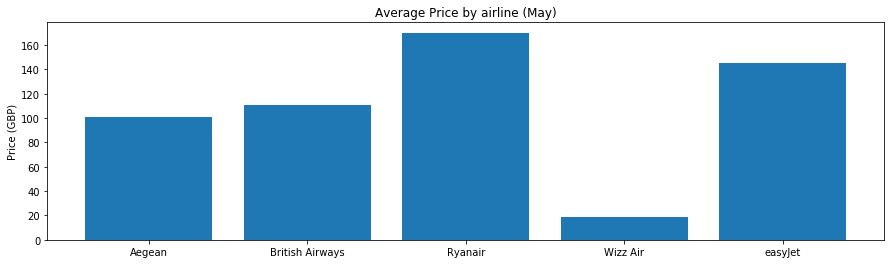

In [8]:
by_airline = data[data.Month==month].groupby(['Airline'])['Price'].mean()

plt.figure(figsize=(15, 4))
plt.bar(by_airline.index,by_airline.values)
plt.ylabel('Price (' + data.iloc[0].Currency + ')')
plt.title('Average Price by airline (' + month_name + ')' )
plt.show()


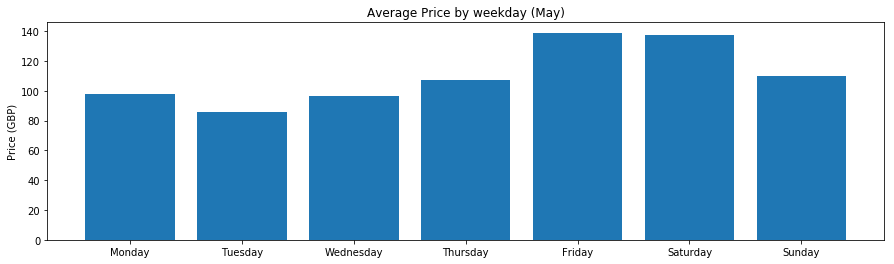

In [9]:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
by_weekday = data[data.Month==month].groupby(['Weekday'])['Price'].mean()
by_weekday = by_weekday.reindex(cats)

plt.figure(figsize=(15, 4))
plt.bar(by_weekday.index,by_weekday.values)
plt.ylabel('Price (' + data.iloc[0].Currency + ')')
plt.title('Average Price by weekday (' + month_name + ')' )
plt.show()

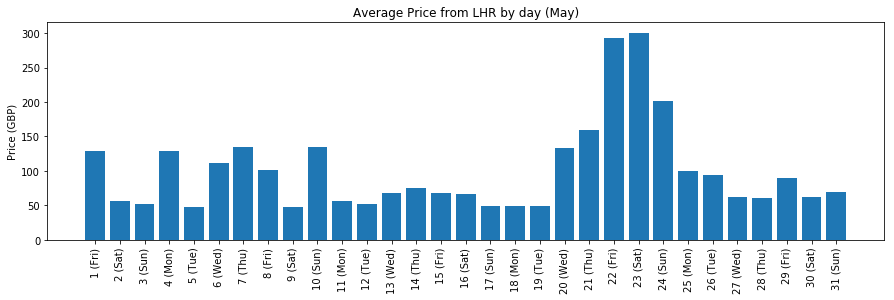

In [10]:
airports = ['LHR']

data['Day_weekday'] = data['Day'].astype(str) + ' (' + data['Weekday'].str[:3] + ')'

by_day = data[(data.Month==month) & data.Origin.isin(airports)].groupby(['Day','Day_weekday'])['Price'].mean().reset_index()
plt.figure(figsize=(15, 4))
plt.bar(by_day['Day_weekday'],by_day['Price'])
plt.xticks(rotation=90)
plt.ylabel('Price (' + data.iloc[0].Currency + ')')

airports_list = airports[0]
for airport in airports[1:]:
    airports_list += ', ' + airport

plt.title('Average Price from ' + airports_list + ' by day (' + month_name + ')' )
plt.show()

data = data.drop(['Day_weekday'],axis=1)

**Search flights under given specs:**

In [72]:
def filter_flights(dates=None, months=None, weekdays='All', airports='All', airlines='All', dep_time_before = None, dep_time_after = None, arr_time_before = None, arr_time_after = None, query='All'):
       
    if dates:
        weekdays == 'All' #If specific date is provided then neglect weekdays field
    
    if dates:
        dates = [dates] if isinstance(dates, int) else dates
    else:
        dates = data.Day.unique()
    
    if months:
        months = [months] if isinstance(months, int) else months
    else:
        months = data.Month.unique()
     
    if weekdays == 'All':
        weekdays = data.Weekday.unique()
    elif isinstance(weekdays, str):
        weekdays = [weekdays]

    if airports == 'All':
        airports = data.Origin.unique()
    elif isinstance(airports, str):
        airports = [airports]
        
    if airlines == 'All':
        airlines = data.Airline.unique()
    elif isinstance(airlines, str):
        airlines = [airlines]
    
    dep_time_before = datetime.time(23,59,0) if dep_time_before == None else datetime.datetime.strptime(dep_time_before, '%H:%M').time()
    dep_time_after = datetime.time(0,0,0) if dep_time_after == None else datetime.datetime.strptime(dep_time_after, '%H:%M').time()
    
    arr_time_before = datetime.time(23,59,0) if arr_time_before == None else datetime.datetime.strptime(arr_time_before, '%H:%M').time()
    arr_time_after = datetime.time(0,0,0) if arr_time_after == None else datetime.datetime.strptime(arr_time_after, '%H:%M').time()
    
    flights = data[(data.Day.isin(dates))&(data.Month.isin(months))&(data.Weekday.isin(weekdays))&(data.Origin.isin(airports))&(data.Airline.isin(airlines))&(data['Dep Time (local)']<dep_time_before)&(data['Dep Time (local)']>dep_time_after)&(data['Arr Time (local)']<arr_time_before)&(data['Arr Time (local)']>arr_time_after)]
    
    if query == 'Cheapest':
        flights = flights[flights.Price==min(flights.Price)]
    
    flights = flights.sort_values(by=['Price'])
    flights = flights[['Origin', 'Destination', 'Airline', 'Flight Date', 'Weekday', 'Dep Time (local)', 'Arr Time (local)', 'Price', 'Currency']]
    
    return flights    

In [73]:
filter_flights(weekdays='Friday', months=[5,6], airports='All', airlines='Aegean', query='All', dep_time_after='18:00')

,Origin,Destination,Airline,Flight Date,Weekday,Dep Time (local),Arr Time (local),Price,Currency
35,LHR,ATH,Aegean,2020-05-15,Friday,22:15:00,02:50:00,49,GBP
90,LHR,ATH,Aegean,2020-05-29,Friday,22:15:00,02:50:00,49,GBP
133,LHR,ATH,Aegean,2020-06-05,Friday,22:15:00,02:50:00,71,GBP
189,LHR,ATH,Aegean,2020-06-12,Friday,22:15:00,02:50:00,123,GBP
244,LHR,ATH,Aegean,2020-06-19,Friday,22:15:00,02:50:00,143,GBP
302,LHR,ATH,Aegean,2020-06-26,Friday,22:15:00,02:50:00,168,GBP
64,LHR,ATH,Aegean,2020-05-22,Friday,22:15:00,02:50:00,433,GBP


In [79]:
filter_flights(weekdays=['Thursday','Friday'], months=8, airports=['LHR','LGW'], airlines='All', query='Cheapest', dep_time_after='19:00')

,Origin,Destination,Airline,Flight Date,Weekday,Dep Time (local),Arr Time (local),Price,Currency
751,LHR,ATH,Aegean,2020-08-28,Friday,22:15:00,02:50:00,71,GBP


In [89]:
filter_flights(dates=list(range(1,10)), months=8, airports=['LHR','LGW'], airlines='All', query='All', dep_time_after='19:00')

,Origin,Destination,Airline,Flight Date,Weekday,Dep Time (local),Arr Time (local),Price,Currency
565,LHR,ATH,Aegean,2020-08-02,Sunday,22:15:00,02:50:00,107,GBP
566,LHR,ATH,British Airways,2020-08-02,Sunday,20:40:00,01:20:00,107,GBP
616,LHR,ATH,Aegean,2020-08-09,Sunday,22:15:00,02:50:00,107,GBP
593,LHR,ATH,British Airways,2020-08-06,Thursday,20:40:00,01:20:00,121,GBP
608,LHR,ATH,British Airways,2020-08-08,Saturday,20:40:00,01:20:00,128,GBP
617,LHR,ATH,British Airways,2020-08-09,Sunday,20:40:00,01:20:00,128,GBP
579,LHR,ATH,British Airways,2020-08-04,Tuesday,20:40:00,01:20:00,135,GBP
575,LHR,ATH,British Airways,2020-08-03,Monday,20:40:00,01:20:00,143,GBP
591,LHR,ATH,British Airways,2020-08-05,Wednesday,20:40:00,01:20:00,143,GBP
558,LHR,ATH,British Airways,2020-08-01,Saturday,20:40:00,01:20:00,179,GBP
